Notebook: Ticker-Specific LSTM Model Evaluation

Objective

This notebook evaluates the LSTM machine learning model trained for individual stock tickers. It dynamically loads the corresponding LSTM model and scaler to:
1.	Make predictions on stock prices (Adj Close) using the processed features.
2.	Assess the model’s performance using evaluation metrics.
3.	Visualize the results with comparison graphs and residual analysis.

Import Required Libraries

This section imports necessary libraries for:

•	Data Manipulation and Querying: pandas, sqlite3

•	Model Loading and Evaluation: keras.models, joblib, sklearn.metrics

•	Visualization: matplotlib.pyplot

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import sqlite3
import matplotlib.pyplot as plt


Set Default Ticker

•	Purpose: Defines the stock ticker to evaluate. By default:

•	Ticker: XOM (Exxon Mobil).

•	Can be dynamically updated in the future using a web app.

•	Output: Confirms the ticker being evaluated.

In [2]:

# Define the default ticker to evaluate
default_ticker = "XOM"
print(f"Evaluating model for Ticker: {default_ticker}")


Evaluating model for Ticker: XOM


Load Processed Data

•	Purpose: Fetches stock data for the specified ticker from the SQLite database.

•	Steps:

1.	Define the database path (stocks_data.db).

2.	Query the processed_stocks table for the selected ticker.

3.	Load the data into a pandas DataFrame.

	•	Output: Displays the number of rows loaded.

In [3]:

# Path to SQLite database and saved models
db_path = 'database/stocks_data.db'

# Load Test Data
with sqlite3.connect(db_path) as conn:
    query = "SELECT * FROM processed_stocks"
    data = pd.read_sql(query, conn)

print(f"Loaded data for evaluation: {data.shape[0]} rows")


Loaded data for evaluation: 67834 rows


Load LSTM Model and Scaler

•	Purpose: Load the pre-trained LSTM model and scaler for the selected ticker.

•	Steps:

1.	Define paths to the model (.h5) and scaler (.pkl).

2.	Use Keras to load the model and joblib to load the scaler.

	•	Output: Confirms successful loading of the model and scaler.

In [4]:

# Load the LSTM model and scaler for the selected ticker
model_path = f'models/model_{default_ticker}_lstm.h5'
scaler_path = f'models/scaler_{default_ticker}_lstm.pkl'

model = load_model(model_path)  # Use Keras to load LSTM models
scaler = joblib.load(scaler_path)

print(f"Loaded LSTM model and scaler for Ticker: {default_ticker}")


Loaded LSTM model and scaler for Ticker: XOM


Prepare Features and Target

•	Features (X):

•	Independent variables used for predictions:

•	7-day MA, 14-day MA, Volatility, Lag_1, Lag_2.

•	Target (y):
    
•	Dependent variable to predict: Adj Close (Adjusted Closing Price).

In [5]:

# Define features and target
features = ['7-day MA', '14-day MA', 'Volatility', 'Lag_1', 'Lag_2']
target = 'Adj Close'

X = data[features]
y = data[target]

Normalize Features

•	Purpose: Ensures input features are scaled consistently using the pre-trained scaler.

•	Steps:

1.	Normalize features (X) using the transform method of the loaded scaler.

2.	Reshape the features for the LSTM model to fit the expected input dimensions: (samples, timesteps, features).

In [6]:

# Normalize the features
X_scaled = scaler.transform(X)

# Reshape the features for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])


Make Predictions

•	Purpose: Use the LSTM model to predict the stock prices.

•	Output: Flatten the predictions for easier analysis.

In [7]:

# Make Predictions
y_pred = model.predict(X_scaled).flatten()

2120/2120 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step


Evaluate Model Performance

•	Purpose: Assess model performance using the following metrics:

1.	Mean Absolute Error (MAE): Average magnitude of prediction errors.

2.	Mean Squared Error (MSE): Average squared prediction errors.

3.	Root Mean Squared Error (RMSE): Square root of MSE.

4.	R² Score: Proportion of variance explained by the model.

	•	Output: Displays key evaluation metrics.

In [8]:

# Evaluate Model Performance
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print("LSTM Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


LSTM Model Evaluation Metrics:
Mean Squared Error (MSE): 4.16
Mean Absolute Error (MAE): 1.12
Root Mean Squared Error (RMSE): 2.04
R² Score: 1.00


Visualization 1: Actual vs. Predicted Values

•	Purpose: Compare actual stock prices with predicted prices.

•	Output: Line plot of Actual vs. LSTM Predicted.

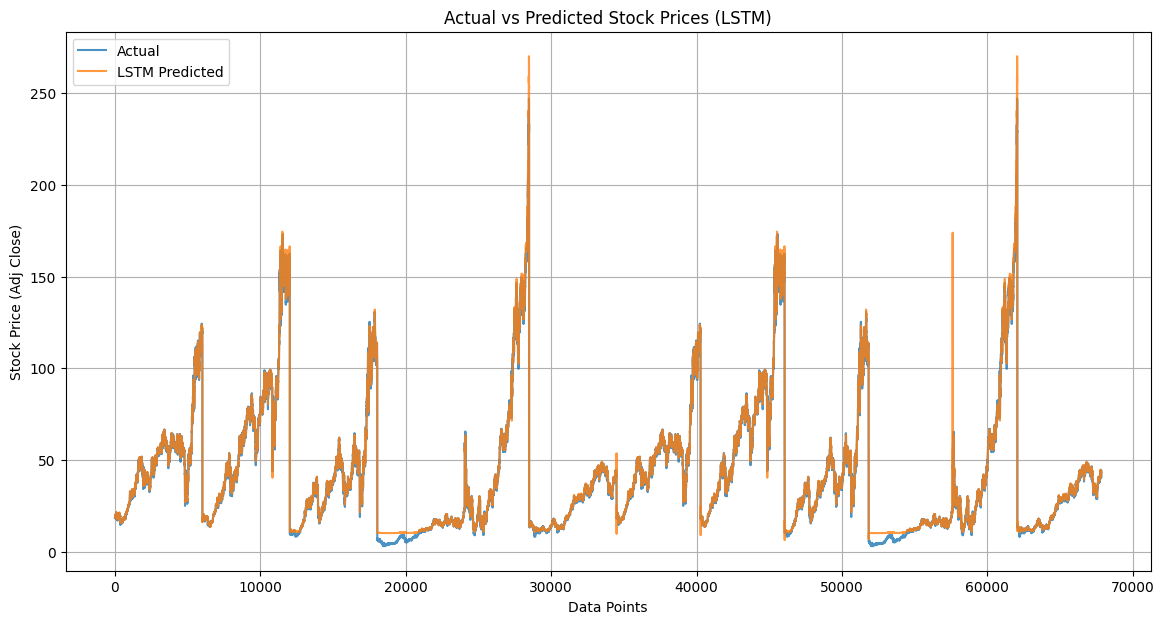

In [9]:

# Visualization: Actual vs Predicted Values
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Actual', alpha=0.8)
plt.plot(y_pred, label='LSTM Predicted', alpha=0.8)
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Data Points')
plt.ylabel('Stock Price (Adj Close)')
plt.legend()
plt.grid()
plt.show()


Visualization 2: Residuals Distribution

•	Purpose: Analyze the distribution of residuals (differences between actual and predicted prices).

•	Output: Histogram with a vertical red dashed line at zero.

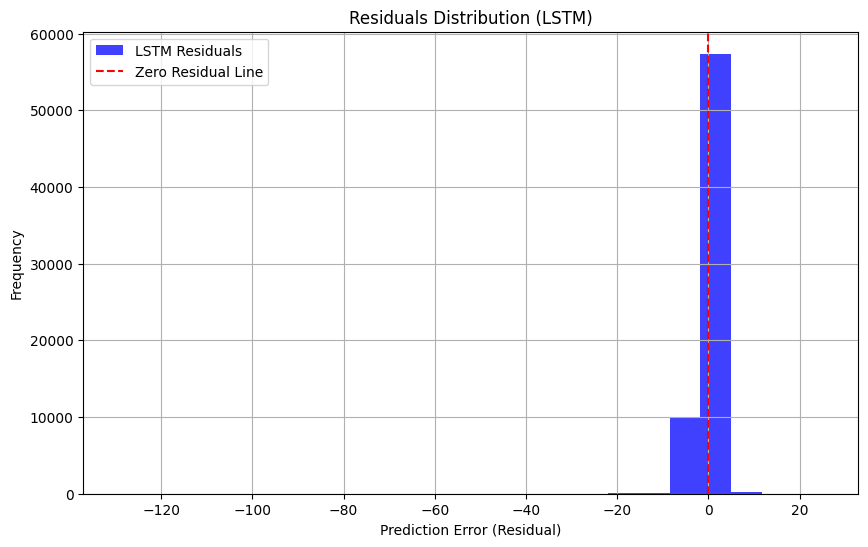

In [10]:

# Visualization: Residuals
residuals_lstm = y - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals_lstm, bins=23, alpha=0.75, color='blue', label='LSTM Residuals')
plt.axvline(x=0, color='red', linestyle='--', label="Zero Residual Line")
plt.title('Residuals Distribution (LSTM)')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


Visualization 3: Scatter Plot of Actual vs. Predicted

•	Purpose: Visualize the relationship between actual and predicted values.

•	Output: Scatter plot with a red dashed line representing the ideal fit.

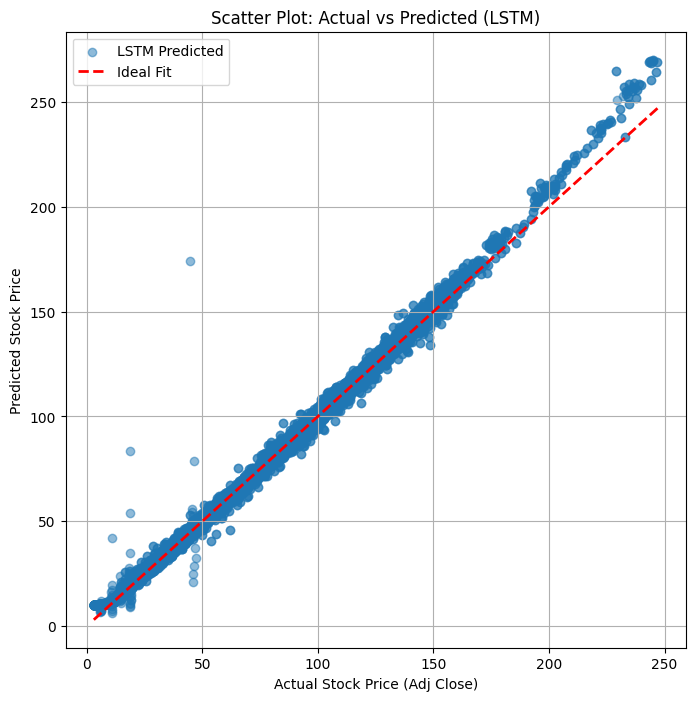

In [11]:

# Visualization: Scatter Plot of Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.5, label='LSTM Predicted')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.title('Scatter Plot: Actual vs Predicted (LSTM)')
plt.xlabel('Actual Stock Price (Adj Close)')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.grid()
plt.show()

Conclusion

This notebook successfully evaluates the LSTM model for the selected ticker (XOM) by:

1.	Loading the model and scaler.

2.	Predicting stock prices based on preprocessed features.

3.	Providing insights into model performance using metrics and visualizations.